# Introduction

This Notebook shows how to make a deep learning Model for generating caption for any given image. The model will have three parts:

**Image Feature Extractor** - 50 layer ResNet model which is pretrained on ImageNet dataset. We will remove the outer 2 dense layer from the architecture and will use the feature extractor part of ResNet to preprocess our image dataset.

**Caption Processor** - This model will have one embedding layer with LSTM to process our captions text.

**Image_Caption_Combination** - We will prepare the input dictionary to feed to the final model by mapping the image and text.

**Final Model** - This is the final model in which we input the image features extracted by the "Image Feature Extractor" and text features extracted by the "Caption Processor" and train it to generate captions for any given image.

We will go step by step in training the model from worst to best. 


# Data Preparation

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import os

In [3]:
image_dataset_path = './Flickr8k_Dataset/Flicker8k_Dataset'
caption_dataset_path = './Flickr8k_text/Flickr8k.token.txt'

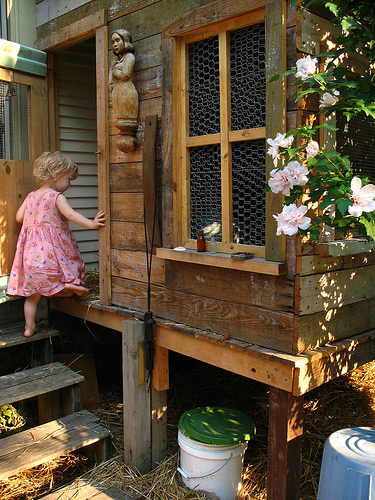

In [4]:
from IPython.display import Image
Image('./Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

# Caption Processor

In [5]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

# Preprocess the captions



1) Convert the captions into lowercase

2) Tokenize the captions into different tokens

3) Remove all the punctuations from the tokens

4) add "start_index" and "end_index" as pointers to tell the model start of the caption and end of the caption

In [6]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'
    

In [7]:
# delete unwanted 
del captions_dict

In [8]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"1000268201_693b08cb0e" : startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [9]:
len(new_captions_dict)

8092

## Make a list of only those images who has caption

In [10]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [11]:
caption_images_list[0]

'1000268201_693b08cb0e'

In [12]:
len(caption_images_list)

8091

# Make training, validation and test data

### taking 7081 images for training, 1000 for validation and rest 10 for testing

In [13]:
train_validate_images = caption_images_list[0:8081]  

In [14]:
test_images = caption_images_list[8081:8091]
test_images

['98377566_e4674d1ebd',
 '985067019_705fe4a4cc',
 '987907964_5a06a63609',
 '989754491_7e53fb4586',
 '989851184_9ef368e520',
 '990890291_afc72be141',
 '99171998_7cc800ceef',
 '99679241_adc853a5c0',
 '997338199_7343367d7f',
 '997722733_0cb5439472']

# Image Feature Extractor

**extract_features** function extracts the important features out of the images passed using VGG16 model.

In [17]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

In [15]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = ResNet50()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
        print('>%s' % name)
        

    return features

## ALERT: Following piece of code takes time 

In [16]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None
>1000268201_693b08cb0e
>1001773457_577c3a7d70
>1002674143_1b742ab4b8
>1003163366_44323f5815
>1007129816_e794419615
>1007320043_627395c3d8
>1009434119_febe49276a
>1012212859_01547e3f17
>1015118661_980735411b
>1015584366_dfcec3c85a
>101654506_8eb26cfb60
>101669240_b2d3e7f17b
>1016887272_03199f49c4
>1019077836_6fc9b15408
>1019604187_d087bf9a5f
>1020651753_06077ec457
>1022454332_6af2c1449a
>1022454428_b6b660a67b
>1022975728_75515238d8
>102351840_323e3de834
>1024138940_f1fefbdce1
>102455176_5f8ead62d5
>1026685415_0431cbf574
>1028205764_7e8df9a2ea
>1030985833_b0902ea560
>103106960_e8a41d64f8
>103195344_5d2dc613a3
>103205630_682ca7285b
>1032122270_ea6f0beedb
>1032460886_4a598ed535
>1034276567_49bb87c51c
>104136873_5b5d41be75
>1042020065_fb3d3ba5ba
>1042590306_95dea0916c
>1045521051_108ebc19be
>1048710776_bb5b0a5c7c
>1052358063_eae6744153
>105342180_4d4a40b47f
>1053804096_ad278b25f1
>1055623002_8195a43714
>1055753357_4fa3d8d693
>1056249424_ef2a2e041c
>1056338697_4f7d7ce270
>1056359656_662

>1379026456_153fd8b51b
>1383698008_8ac53ed7ec
>1383840121_c092110917
>1384292980_4022a7520c
>1386251841_5f384a0fea
>1386964743_9e80d96b05
>138705546_be7a6845dd
>138718600_f430ebca17
>1387443857_602ab6f9bf
>1387461595_2fe6925f73
>1387785218_cee67735f5
>1388346434_524d0b6dfa
>1388373425_3c72b56639
>1388970365_162edcceb4
>1389264266_8170bc1c54
>1389323170_d1c81d6b51
>1389651420_8d95d8f6ed
>1390268323_2c8204e91c
>1392272228_cf104086e6
>1394368714_3bc7c19969
>1394396709_65040d97ab
>1394599090_fe0ba238f0
>1394620454_bf708cc501
>1394927474_0afdd82fc4
>1396064003_3fd949c9dd
>1396703063_e8c3687afe
>1397295388_8a5b6b525d
>1397887419_e798697b93
>1397923690_d3bf1f799e
>1398606571_f543f7698a
>1398613231_18de248606
>1398873613_7e3174dd6c
>1400424834_1c76e700c4
>1401961581_76921a75c5
>1402640441_81978e32a9
>1402641725_5e027ecaa7
>1402843760_d30f1dbf0f
>1402859872_0fc8cf8108
>1403414927_5f80281505
>140377584_12bdbdf2f8
>140430106_2978fda105
>1404832008_68e432665b
>1405221276_21634dcd58
>140526326_da07

>1801063894_60bce29e19
>1801188148_a176954965
>1801663973_5ad393caeb
>1801874841_4c12055e2f
>1802092493_7b44fdb6b9
>1803631090_05e07cc159
>180506881_de0f59770f
>1805990081_da9cefe3a5
>1806580620_a8fe0fb9f8
>1807169176_7f5226bf5a
>1808007704_ee8a93abb4
>1808370027_2088394eb4
>1808504612_3508f3c9bb
>1809758121_96026913bb
>1809796012_a2dac6c26b
>1810651611_35aae644fb
>181103691_fb2f956abd
>181157221_e12410ef0b
>1812525037_528465037c
>1813266419_08bf66fe98
>1813597483_3f09d2a020
>1813777902_07d1d4b00c
>1814086703_33390d5fc7
>181415975_2627aa6668
>1814391289_83a1eb71d3
>181777261_84c48b31cb
>1818403842_553a2a392c
>1819261140_6c022f4b1d
>1821238649_2fda79d6d7
>182493240_40410254b0
>1827560917_c8d3c5627f
>1835511273_790eaae6e6
>1836335410_de8313a64e
>1837976956_3c45d0f9b8
>185057637_e8ada37343
>1858963639_4588cd4be9
>185972340_781d60ccfd
>1859726819_9a793b3b44
>1859941832_7faf6e5fa9
>1860543210_47e94cf652
>186346360_541047336f
>186348874_75b2cf1ec5
>1865794069_6e3a1e57bb
>186890601_8a6b0f1769

>2140305708_591d10b54d
>2140747429_62cfd89ae9
>2141065212_463a6997e1
>2141713971_e25eb12712
>2142232919_c857a09dd7
>2144049642_070cf541b4
>2144050118_3e7d2e05b1
>2144846312_d4c738dc6c
>214501174_6db1f4d69c
>214543992_ce6c0d9f9b
>2147199188_d2d70b88ec
>2148013097_6a4f495bc5
>2148695079_9ae6a9b1c7
>2148916767_644ea6a7fa
>2148991939_3b9fd6c439
>2149968397_a7411729d1
>2149982207_5345633bbf
>2150564996_d173a506d7
>2151056407_c9c09b0a02
>2151300603_248a9fe715
>215214751_e913b6ff09
>2156131463_5b53636cf0
>2156726763_034ecd2e39
>2157003092_eaeb977789
>2157173498_2eea42ee38
>2158247955_484f0a1f11
>2158267555_db1d94e468
>215876547_fa584c5ec3
>2159447283_fab8c272b0
>2160266952_a2ab39191b
>216172386_9ac5356dae
>2161799386_27aa938421
>2162469360_ff777edc95
>2162564553_96de62c7e6
>2164363131_6930455d45
>2165459064_5b81ff23eb
>2165461920_1a4144eb2b
>2165677531_e1d5e086f7
>2167644298_100ca79f54
>2169067981_cc19268f23
>2169951750_495820a215
>2170187328_65c2f11891
>2170222061_e8bce4a32d
>2171154778_8189

>2286270205_16038dec5a
>2286823363_7d554ea740
>2287023569_fd7a9c60b8
>2287887341_663bfa15af
>2288099178_41091aa00c
>2288315705_5f4c37d932
>2288530008_4ebcee2174
>2289068031_fe26990183
>2289096282_4ef120f189
>2289212650_69de7a20b2
>228949397_9e63bfa775
>2290330500_e7bdaa58e1
>2290589734_b588471345
>2291485126_b8d41a63f4
>2291511815_ac083fddbd
>2292406847_f366350600
>2293149170_38fb2257ea
>2293424366_7b5fcd2398
>2294516804_11e255807a
>2294598473_40637b5c04
>2294688426_96c8614f1d
>2295216243_0712928988
>2295447147_458cfea65a
>2295750198_6d152d7ceb
>2295894587_2fd8faf550
>2296166785_292a4e9f4c
>2297471897_3419605c16
>2297744130_f571f3a239
>2298077331_f9a1488067
>2298097636_c5de0079de
>2298283771_fb21a4217e
>229862312_1a0ba19dab
>2298661279_016d87ba2f
>2298946012_22de913532
>2299427360_422a3fb8b0
>229951087_4c20600c32
>229954612_a4438297ee
>229978782_3c690f5a0e
>2299859649_07ca44a222
>230016181_0c52b95304
>2300168895_a9b83e16fc
>2300229745_af7a20c959
>2300920203_f29260b1db
>2301379282_5fbcf

>241347441_d3dd9b129f
>241347460_81d5d62bf6
>241347496_1a35fec8dc
>241347547_902725b9f8
>241347580_a1e20321d3
>241347611_cb265be138
>241347635_e691395c2f
>241347664_4a3e7e5be7
>241347689_d0b1ac297d
>241347700_ef2451d256
>241347760_d44c8d3a01
>241347803_afb04b12c4
>241347823_6b25c3e58e
>241374292_11e3198daa
>2414352262_005ae90407
>2414384480_096867d695
>2414390475_28a0107bb0
>2414397449_2ac3b78e0d
>2414710960_a4cde4af60
>2414986483_004936f84b
>2415265825_fbfe0c8556
>2415803492_56a673dc25
>2416964653_db3c2b6a0e
>2417341107_97dbab9c5e
>2417623030_afdc1024b5
>2417745327_a2c2705043
>2418191216_82711d5c5c
>2419186511_f0ce5f9685
>2419221084_01a14176b4
>2419591925_1038c6c570
>2419797375_553f867472
>2420546021_4a59790da6
>242064301_a9d12f1754
>2420696992_22e0dd467d
>2420730259_86e7f8a815
>242109387_e497277e07
>2421446839_fe7d46c177
>2422018883_336519b5c6
>2422302286_385725e3cf
>2422482455_b98d9c2120
>2423085253_6c19149855
>2423138514_950f79e432
>242324909_06d5a6c44b
>2423292784_166ee54e0b
>2423

>2522809984_2e8a7df4fb
>2524003134_580e74328b
>2524084967_a5e011b73d
>252504549_135b0db5a3
>2525232298_cf42d415ab
>2525270674_4ab536e7ec
>2525455265_f84ba72bd7
>2525666287_638ab5e784
>2525716531_e6dedee421
>252578659_9e404b6430
>2526041608_a9775ab8d7
>2526585002_10987a63f3
>2527163162_d0fb802992
>2527303359_6c3dc3f282
>2527713011_b0ec25aa54
>252802010_3d47bee500
>252846811_7b250935a7
>2528489543_546c1ca81f
>2528521798_fb689eba8d
>2528547068_7d37479b9b
>2528552898_9e49a7033f
>2529116152_4331dabf50
>2529205842_bdcb49d65b
>2531531628_b4a5041680
>2531837969_6f28637811
>2531942624_c3c072064e
>2532262109_87429a2cae
>2532294586_4cd76a837d
>2533010184_ef2fd71297
>2533076864_d799996433
>2533414541_362bf043bb
>2533424347_cf2f84872b
>2533642917_a5eace85e6
>2534194182_ac53035cf4
>2534424894_ccd091fcb5
>2534502836_7a75305655
>2534652796_c8a23288ab
>2535746605_8124bf4e4f
>2537119659_fa01dd5de5
>2537197415_af7c30dfc8
>2537583012_4a358a6a8a
>253762507_9c3356c2f6
>2538423833_d1f492d1fb
>2538477523_1da7

>2642475077_69d19deb74
>2642688531_8fb68b2147
>2643263887_a32ffb878f
>2643309379_2cde08516c
>2644326817_8f45080b87
>2644430445_47c985a2ee
>2644916196_16f91dae54
>2644920808_f5a214b744
>2646046871_c3a5dbb971
>2646116932_232573f030
>2646540383_343e1ec9a4
>2646615552_3aeeb2473b
>2647049174_0fb47cee2e
>2647062476_5ef31ba867
>2647229826_e0e0c65ef1
>2647394564_4843800cff
>2647593678_1fa3bb516c
>2648165716_02e2e74fd6
>2648310638_d6c576b5e4
>264859622_f3a00ab409
>264928854_d9e61f3a8e
>2649406158_ded6be38de
>2649705487_4605e879e9
>2649850541_59a6c7f01c
>2650485780_29d89268d7
>2650568697_ffb79bf2ea
>2650620212_0586016e0d
>2651915425_7a58e862e9
>2652155912_8ba5426790
>265223843_9ef21e1872
>265223847_636ba039c1
>2652522323_9218afd8c2
>2653552905_4301449235
>2654514044_a70a6e2c21
>2654943319_d17fee7800
>2655183854_5852790214
>2655196158_5c878a4af0
>265528702_8653eab9fa
>2655647656_ee450446ed
>2656039837_f46b29af92
>2656688132_d93be870e0
>2656749876_e32495bd8c
>2656890977_7a9f0e4138
>2656987333_80dc

>2761599088_8b39cc5f41
>2762301555_48a0d0aa24
>2762702644_2aa3bf9680
>2763044275_aa498eb88b
>276356412_dfa01c3c9e
>2763601657_09a52a063f
>2764178773_d63b502812
>2764732789_1392e962d0
>2765029348_667111fc30
>2765747519_2b851e01d6
>2766148353_70b2e8070f
>2766291711_4e13a2b594
>2766325714_189bbff388
>2766630484_ce73f47031
>2766726291_b83eb5d315
>2766765386_4c0beb939d
>2766854400_640e2abe08
>2766926202_4201bf2bf9
>276699720_fe6718fd03
>2768021570_46bc6325e3
>2768248810_06d543c080
>2768662025_44001fe5d1
>2768972186_92787cd523
>2769605231_dae8b30201
>2769731772_18c44c18e2
>2771424045_1fdf9617eb
>2772084628_c0ae29d87a
>2772532341_c4597a94ed
>2773011586_6f4cd41e84
>2773400732_5b65a25857
>2773682293_3b712e47ff
>2774362575_7543b8bf19
>2774430374_fee1d793e7
>2774554310_007e980a90
>2774581025_81a3074e2e
>2774705720_1cb85812dc
>2775249812_f4db95e818
>2775744946_1ab5d500a2
>2776029171_5abdd5a22f
>2777021428_0b2ac3e987
>27782020_4dab210360
>2778290592_1910bb0431
>278002800_3817135105
>278002875_d011a

>288025239_5e59ba9c3b
>2880874989_a33b632924
>2881087519_ca0aa79b2b
>2881441125_b580e3dd4b
>2881468095_d4ce8c0c52
>288177922_b889f2e1fe
>2882056260_4399dd4d7c
>2882483779_73c171ac19
>2882589788_cb0b407a8d
>2882743431_c3e6cd1b5c
>2882893687_1d10d68f2b
>2883099128_0b056eed9e
>2883324329_24361e2d49
>2883907436_82bf4a36b8
>2883950737_3b67d24af4
>2884092603_786b53a74b
>2884252132_5d8e776893
>2884301336_dc8e974431
>2884400562_e0851014fc
>2884420269_225d27f242
>2884651479_12e400ee58
>288508162_1727873924
>2885111681_dc328ecfff
>2885382946_f541ea5722
>2885387575_9127ea10f1
>2885891981_6b02620ae9
>2885912662_a3a2dfde45
>2886411666_72d8b12ce4
>2886533440_dfa832f2fa
>2886837407_a4510ab1ef
>2887103049_a867e74358
>2887171449_f54a2b9f39
>2887614578_ed7ba21775
>2887744223_029f2fd5fe
>2887750774_920eb171aa
>2887798667_ce761d45e8
>2888386138_578d21033a
>2888408966_376c195b3f
>2888658480_e922a3dec2
>2888702775_0939a6680e
>2888732432_7e907a3df1
>288880576_818b6ecfef
>2890057168_c712f932e0
>2890075175_4bd

>2985439112_8a3b77d5c9
>2985679744_75a7102aab
>2986280913_13fb2d472e
>2986620935_e97763983d
>2986671935_0c60bbb3fa
>2986716822_e220754d32
>2987096101_a41896187a
>2987121689_f9de6c479b
>2987195421_e830c59fb6
>2987328689_96a2d814f1
>2987576188_f82304f394
>2987775031_3f9ac69319
>2988244398_5da7012fce
>2988439935_7cea05bc48
>298920219_9a3f80acc5
>2990471798_73c50c76fb
>2990563425_2f7246f458
>2990977776_1ec51c9281
>2991375936_bf4b0a7dc0
>2991575785_bd4868e215
>2991771557_d98fa0a69f
>299178969_5ca1de8e40
>299181827_8dc714101b
>2991993027_36ac04e9a0
>2991994415_504d1c0a03
>2991994607_06f24ec7a6
>2992614450_b5a6692239
>2992658871_ac786d37a6
>2992808092_5f677085b7
>2992999413_018f48aabc
>2993049054_611f900644
>2993167183_2bda95fa3d
>2993167197_e5d0a73530
>2993388841_6746140656
>2994104606_bc2df6c1f4
>2994107810_af56326389
>2994179598_a45c2732b5
>2994205788_f8b3f2e840
>2995461857_dd26188dcf
>299572828_4b38b80d16
>2995935078_beedfe463a
>299612419_b55fe32fea
>299676757_571ee47280
>2998024845_1529c

>3084034954_fe5737197d
>3084149186_4bc08b0752
>3084380974_268a0f9236
>3084711346_fda0f5a3e6
>3084731832_8e518e320d
>308487515_7852928f90
>3085226474_62aba51179
>3085357792_efcf297c71
>3085667767_66041b202e
>3085667865_fa001816be
>3085973779_29f44fbdaa
>3086507638_d8a2cd0ac3
>3086523890_fd9394af8b
>3086526292_f799d237c7
>3086790344_9487c58624
>3086810882_94036f4475
>3087095548_6df7c2a8ed
>3087485737_cb09bc80b6
>3088074124_481139dc92
>3088322308_b0c940b3a3
>3088399255_1bd9a6aa04
>3088572348_264c47f78c
>3088677667_4a8befb70e
>3088922727_4bdf2ccc94
>3089107423_81a24eaf18
>308956341_642589e9cc
>3089742441_d42531c14f
>3089842255_359ccf5c40
>3090386315_87ed417814
>3090398639_68c0dfa9a5
>309049466_1d7e7d5fc2
>3090593241_93a975fe2b
>3090600019_8808fe7a9d
>3090957866_f1b2b7f214
>3091177347_58c85c1c3b
>3091338773_9cf10467b4
>3091382602_60b9b53ed1
>3091580843_178042c50b
>3091594712_2166604334
>3091912922_0d6ebc8f6a
>3091916691_b1c96669c6
>3091921457_83eee69591
>3091962081_194f2f3bd4
>3092200805_dd

>3168123064_d1983b8f92
>316833109_6500b526dc
>3168354472_866fe70d36
>3168796547_0c14b368f9
>3168841415_c0705a327a
>3169276423_6918dd4da1
>3169394115_2193158cee
>3169591322_d0b6d0cd04
>3169777863_d745865784
>3170110692_d1e0e66cee
>3170551725_1276644eab
>3170802797_3c851bb475
>3170856184_efabfd0297
>3170897628_3054087f8c
>3171035252_dba286ae5c
>3171066023_ec60ba30f3
>317109978_cb557802e1
>3171188674_717eee0183
>3171250845_5ae0d2a8bc
>3171347658_f0d5469c56
>3171451305_f87b9e09ee
>3171651115_e07b9d08f6
>3172280520_e7655fb596
>3172283002_3c0fc624de
>3172369593_eb4d787ffb
>3172384527_b107385a20
>3173014908_b3e69594b6
>3173157541_70b16b4318
>3173215794_6bdd1f72d4
>3173461705_b5cdeef1eb
>317383917_d8bfa350b6
>3173928684_4ea0ee5114
>3173976185_8a50123050
>3174156702_95a1cda2d9
>3174196837_800689a2f3
>3174228611_6cf9d2266b
>3174417550_d2e6100278
>3174431688_ae84778db0
>3174453534_fcc927c647
>3174713468_e22fa7779e
>3174726084_c108de0a64
>317488612_70ac35493b
>3175434849_859f09fe07
>3175446111_681

>3242354561_54e5a34925
>3242718240_3358f2d6e6
>3242808166_8638150274
>3242919570_39a05aa2ee
>3243020805_2bafc36c45
>3243094580_ccd01679f5
>3243233886_235a80e8c7
>324355356_859988a710
>3243588540_b418ac7eda
>3243591844_791cfa62eb
>3244171699_ace4b5d999
>3244470342_c08f6bb17e
>3244586044_205d5ae2ba
>3244734844_c318c29c23
>3244747165_17028936e0
>3244910944_612b8ce98f
>3245070961_8977fdd548
>3245250964_9d3e37111e
>3245266444_2e798096e6
>3245460937_2710a82709
>3245504245_27931f5ec1
>3245912109_fdeef6b456
>3245939062_8ffe1d2be5
>3246190363_68d903bfcb
>3246773992_89bf86937b
>3246804978_ea2c9e56f2
>3246991821_750a3097e2
>3247052319_da8aba1983
>3247168324_c45eaf734d
>3247341210_5d1e50df23
>3247423890_163f00a2cb
>3247500085_c4f641aa84
>3247598959_5b2348444c
>3247693965_845b3b4349
>3248220732_0f173fc197
>3248352729_ab264b2222
>3248408149_41a8dd90d3
>3248752274_96740ed073
>3249014584_21dd9ddd9d
>3249062399_0dafe5e4f5
>3249125548_700d874380
>3249278583_95cd8206da
>3249597269_935e0a375a
>3249738122_

>3318564834_4ccea90497
>3318995586_c2bc50b92e
>3319020762_d429d56a69
>3319058642_885d756295
>3319177177_130a72b8ae
>3319338707_892ae2a660
>3319388517_5609ae9805
>3319405494_58dee86b21
>3319489465_c65c91e4f2
>3319586526_3994e9cd58
>3319723910_af5b5f1fae
>3319899418_4bcf1b00d8
>3320032226_63390d74a6
>3320154278_c67e01b8d1
>3320209694_db579cb607
>3320356356_1497e53f80
>3320411267_df70b90501
>332045444_583acaefc3
>3320680380_b0d38b3b4a
>3320756943_9d004f9824
>3321063116_4e5deeac83
>3321334180_8f764e0e0f
>3321516504_5ee97771cb
>3321956909_7b5ddf500f
>3322200641_c2e51ff37b
>3322389758_394c990b6a
>3322443827_a04a94bb91
>3323076458_3ce72a1dae
>3323419265_7fefaa9d5d
>3323498985_fd9d2803fd
>3323514651_3efdbd63ed
>3323528927_7b21081271
>3323661814_1e8e1ae88c
>3323952123_deb50b0629
>3323988406_e3c8fce690
>3324056835_84904fe2f8
>3324375078_9441f72898
>3324746155_71e14f60ce
>3325129757_7a1979ac11
>3325157569_8084ab3293
>3325497914_f9014d615b
>3325578605_afa7f662ec
>3325910784_5ecb88310c
>3325974730_

>3385956569_a849218e34
>3386060324_b98fdfa449
>3386375153_20c56d0aae
>3386893620_5f0bb4e794
>3386953179_84c2d7922f
>3387542157_81bfd00072
>3387630781_f421a94d9d
>3387661249_33e5ba0bc5
>3388094307_5a83be64a5
>3388330419_85d72f7cda
>3388836914_c267cf3a59
>3389321512_b11f499dab
>3389448506_7025e7cc12
>3391209042_d2de8a8978
>3391924827_53b31542ce
>3392019836_c7aeebca1c
>3392293702_ccb0599857
>3392851587_a638ff25e2
>3393035454_2d2370ffd4
>3393152604_27bd1037f2
>3393343330_b13df4d8ec
>3393394134_0caac47e1c
>3393446245_37dd3f3b59
>339350939_6643bfb270
>3393926562_66cc01b001
>3394070357_cb2a3243fc
>3394586927_eae7732b64
>3394654132_9a8659605c
>3394750987_a32ecc477e
>3395173129_f0ac0a1ed4
>3396036947_0af6c3aab7
>3396043950_12783c5147
>3396153660_f729d9f9b9
>3396157719_6807d52a81
>3396251819_1efa69310f
>3396275223_ee080df8b5
>339658315_fbb178c252
>3396817186_b299ee0531
>3397220683_4aca010f86
>3397228832_8ce5b1c26f
>3397259310_1ed1a346b5
>3397310901_cbef5c06ef
>3397633339_d1ae6d9a0e
>3397803103_8

>3457210101_3533edebc8
>3457315666_b943111dec
>3457364788_3514a52091
>3457455611_94ee93929f
>3457460673_800d7f7dd9
>3457572788_e1fe4f6480
>3457604528_302396c08c
>3457784061_8f77f43a9c
>3457856049_2de173e818
>345785626_9fa59f38ce
>3458211052_bb73084398
>3458215674_2aa5e64643
>3458379941_657182bb09
>3458434150_2b0d619244
>3458559770_12cf9f134e
>3458577912_67db47209d
>3458625738_297857369c
>3459156091_c1879ebe28
>3459362347_c412ef9901
>3459419203_cd7c68ce4d
>3459492423_c881f12c9f
>3459570613_3932816d3f
>3459858555_c3f0087a72
>3459871361_92d1ecda36
>3460458114_35037d4d4c
>3460551728_63255cec18
>3461041826_0e24cdf597
>3461049169_e068ae4f25
>3461106572_920c8c0112
>3461110860_37ef15af8e
>3461114418_c27b4043a2
>3461437556_cc5e97f3ac
>3461583471_2b8b6b4d73
>3461677493_5bfb73038e
>3462165890_c13ce13eff
>3462396164_ba9849c14b
>3462454965_a481809cea
>3462512074_2b4db1ffd6
>346253487_687150ab04
>3463034205_e541313038
>3463268965_f22884fc69
>3463523977_f2ed231585
>3463922449_f6040a2931
>3464708890_3

>3527926597_45af299eee
>3528105511_12ff45dc9c
>3528251308_481a28283a
>3528902357_be2357a906
>3528966521_2e871ff6a1
>3529211822_1dabdb3a9c
>3529314899_b4e533bb76
>3529721084_4b405baf54
>352981175_16ff5c07e4
>3530087422_7eb2b2c289
>3530342993_a4a1f0e516
>3530502404_f8c3a3f61c
>3530504007_3272c57e21
>3530687486_6e6be53602
>3530843182_35af2c821c
>353180303_6a24179c50
>3531811969_49af4c22f0
>3532028205_9ddd7599f8
>3532098999_4e07a0a17e
>3532192208_64b069d05d
>3532194771_07faf20d76
>3532200762_b28c39d311
>3532205154_5674b628ea
>3532412342_e0a004b404
>3532539748_795d16ef07
>3532587748_7e64bb223a
>3532593368_be10432e92
>3532761259_14026c1e96
>3532782283_341f0381a3
>3533145793_5d69f72e41
>3533394378_1513ec90db
>3533451027_b078e4631b
>3533470072_87a5b595ba
>3533484468_0787830d49
>3533660418_f3a73a257c
>3533775651_9d7e93dacf
>3533922605_a2b1e276f6
>3534046564_4f8546e364
>3534183988_3763593dfb
>3534512991_f9fd66f165
>3534548254_7bee952a0e
>3534668485_6887629ff0
>3534824784_7133119316
>3534952095_9

>3597146852_3d000a5d5f
>3597210806_95b07bb968
>3597326009_3678a98a43
>3597354819_0069aaf16e
>3597715122_45878432ec
>3597921737_3fd1d0665b
>3597924257_d0da3c5fe6
>359837950_9e22ffe6c2
>3598447435_f66cd10bd6
>3599124739_b7e60cf477
>3599392711_8264881de2
>3599442049_e448c7c9b2
>3599568766_9e96def0ef
>3600221224_945df01247
>3600403707_527aa0596e
>3600909823_ce72c26e66
>3601491447_a338875b51
>3601508034_5a3bfc905e
>3601533527_6c2439113c
>3601569729_bf4bf82768
>3601803640_5f3cb05acf
>3601843201_4809e66909
>3601978895_9fec23ce0c
>3602676311_824b2c04ba
>3602838407_bf13e49243
>3603064161_a8f3b6455d
>3603116579_4a28a932e2
>3603301825_5817727be2
>3603870481_1ebc696d91
>3604314527_5077cd9d43
>3604383863_5e387cb8e6
>3604384157_99241be16e
>3604384383_db6805d1b9
>3604391853_b4809fcb8c
>3604496023_c1f546423e
>3604928725_58147c87cd
>3605061440_1d08c80a57
>3605100550_01214a1224
>3605676864_0fb491267e
>3606084228_6286a52875
>3606093421_eddd46c2c7
>3606355203_1260f43ec0
>3606846822_28c40b933a
>3606909929_

>3673878924_506c9d767b
>3673970325_4e025069e9
>3674168459_6245f4f658
>3674521435_89ff681074
>3674565156_14d3b41450
>3675685612_3987d91d92
>3675742996_02ccef16a3
>3675825945_96b2916959
>3676432043_0ca418b861
>3676460610_8c52e8a355
>3676561090_9828a9f6d0
>367673290_f8799f3a85
>3676788491_01e9bc5f15
>3677239603_95865a9073
>3677302645_8cd3fac70d
>3677318686_b018862bb7
>3677329561_fa3e1fdcf9
>3677514746_26f5588150
>3677613006_4689cb8e4e
>3677693858_62f2f3163f
>3677734351_63d60844cb
>3677860841_3aa9d8036c
>3677927146_1696f0b075
>3677954655_df4c0845aa
>3677964239_6406ed096f
>3678098428_40c1b74cc2
>3678100844_e3a9802471
>367925122_335ed279a8
>3679341667_936769fd0c
>3679405397_bb130ea3c2
>3679407035_708774de34
>3679502342_7fe6ef8a36
>367964525_b1528ac6e4
>3679707139_1cc1e71237
>3680031186_c3c6698f9d
>3680218298_582e6a2289
>3681056426_fbd6c0c92c
>3681172959_6674c118d2
>3681324243_b69fa90842
>3681414069_71ba164f71
>3681575323_433d007650
>3681651647_08eba60f89
>3682038869_585075b5ff
>368212336_bc1

>405537503_f66ecc5073
>405615014_03be7ef618
>405961988_fcfe97f31e
>405970010_8cebaa77d3
>406248253_27b5eba25a
>406642021_9ec852eccf
>406901451_7eafd7568a
>407008823_bdd7fc6ed5
>407569668_19b3f8eaf6
>407678652_1f475acd65
>408233586_f2c1be3ce1
>408573233_1fff966798
>408627152_1feaa4b94e
>408748500_e8dc8c0c4f
>409327234_7b29eecb4e
>410042380_517ccee020
>410413536_11f1127c46
>410422753_de506155fa
>410453140_5401bf659a
>411011549_1298d2b4d2
>411175971_0fffd3b8c6
>411216802_aead9e67e3
>411863595_d77156687e
>412056525_191724b058
>412082368_371df946b3
>412101267_7257e6d8c0
>412203580_2c7278909c
>413231421_43833a11f5
>413737417_b0a8b445e9
>414568315_5adcfc23c0
>414773731_c3f5bf43d5
>415118186_64defc96f3
>415657941_454d370721
>415793623_6c1225ae27
>416106657_cab2a107a5
>416650559_cd08d3cd96
>416788726_5b4eb1466e
>416960865_048fd3f294
>416992999_654a99a903
>417577408_eb571658c1
>417966898_a04f9b5349
>418357172_bdddf71d32
>418616992_22090c6195
>418667611_b9995000f4
>418796494_bdb441de42
>419116771

>506343925_b30a235de6
>506367606_7cca2bba9b
>506412121_67ecc7ec05
>506478284_7cf8bdbe36
>506738508_327efdf9c3
>506808265_fe84ada926
>506882688_b37d549593
>507758961_e63ca126cc
>508261758_78fb8ae067
>508432819_3d055f395d
>508929192_670910fdd2
>508958120_afe274f726
>509123893_07b8ea82a9
>509200598_171a1ab6c8
>509241560_00e5b20562
>509778093_21236bb64d
>510197538_0a11b94460
>510510783_b2cf5d57bb
>510531976_90bbee22a2
>510791586_3913ade6a7
>511282305_dbab4bf4be
>511749704_3037806cb1
>511844627_0ec78e01e9
>512026551_ba63ddbd31
>512031915_0dd03dcdf9
>512045825_1be2083922
>512101751_05a6d93e19
>512163695_51a108761d
>512306469_1392697d32
>512550372_438849ce19
>512634877_d7ad8c8329
>512991147_dc48e6839c
>513116697_ad0f4dc800
>513269597_c38308feaf
>514036362_5f2b9b7314
>514073775_56796be990
>514222285_aa0c8d05b7
>514222303_cb98584536
>514431934_9cf78f05a9
>514905846_b54d13946a
>514990193_2d2422af2c
>515335111_c4afd5b903
>515702827_be3c6ce857
>515755283_8f890b3207
>515797344_4ae75cb9b1
>516214924

>783353797_fdf91bdf4c
>783994497_4f6885454d
>788126442_086334f0cf
>78984436_ad96eaa802
>791338571_7f38510bf7
>792362827_5ab5281b99
>795081510_53fd17d101
>798343627_7492fe0c12
>799199774_142b1c3bb2
>799431781_65dc312afc
>799486353_f665d7b0f0
>801607443_f15956d1ce
>802594049_289e3c8420
>804087017_330bcc8c56
>805682444_90ed9e1ef3
>808245064_8a7971fc5b
>811662356_f9a632b63c
>811663364_4b350a62ce
>812196663_0c969970b5
>816084977_21c1811c9a
>818340833_7b963c0ee3
>820169182_f5e78d7d19
>822836318_21544f0f78
>823675317_b5fbdb17b3
>823697339_aadbeef495
>824123145_59243e504e
>824782868_a8f532f3a6
>824923476_d85edce294
>825918657_d92f1761f4
>827941668_2e4ac6cb39
>832128857_1390386ea6
>835415474_7b7f2a9768
>836768303_d748df5546
>836828001_af98d16256
>837893113_81854e94e3
>837919879_94e3dacd83
>838074897_9d6270b3cd
>839295615_bb9baf2f95
>842960985_91daf0d6ec
>842961005_692737888e
>843616798_5ab0ecb525
>846085364_fc9d23df46
>84713990_d3f3cef78b
>847782643_57248bbdab
>848180689_d67a1361ce
>848293676_9

In [17]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

1000268201_693b08cb0e : [[0.0653595  0.16782568 0.32517606 ... 0.05107118 0.3282122  1.0043384 ]]


In [18]:
len(train_validate_features)

8081

In [19]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features_n.pkl', 'wb'))

## Preparing the input data

Each caption will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained. So we will have two features, x1 (image) , x2 (text_sequence) and one target variable, y (generated_word).

Image,		   text sequence, 						generated_word

photo	         startseq, 									little

photo	       startseq, little,							girl

photo	       startseq, little, girl, 					running

photo	       startseq, little, girl, running, 			in

photo	       startseq, little, girl, running, in, 		field

photo	       startseq, little, girl, running, in, field, endseq

In [20]:
# load libraries
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [21]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

### make sure the correct caption is mapped with the correct image

In [22]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

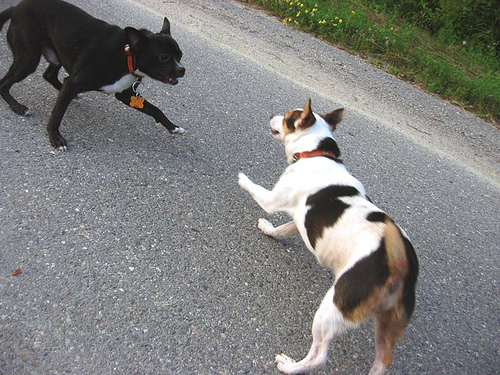

In [23]:
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [24]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [25]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [26]:
len(train_x1)

72253

In [27]:
len(validate_x1)

10284

# Final Model

## Model architecture

In [33]:
# feature extractor model
input_1 = Input(shape=(2048,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 30, 256)           │       1,148,160 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 2048)              │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 30, 256)           │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 30)                │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         524,544 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ dropout_3[0][0],           │
│                               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 256)               │               0 │ dense_3[0][0],             │
│                               │                           │                 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │          65,792 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 4485)              │       1,152,645 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,416,453 (13.03 MB)

 Trainable params: 3,416,453 (13.03 MB)

 Non-trainable params: 0 (0.00 B)

None


## Plot the model architecture

In [34]:
# !pip install graphviz

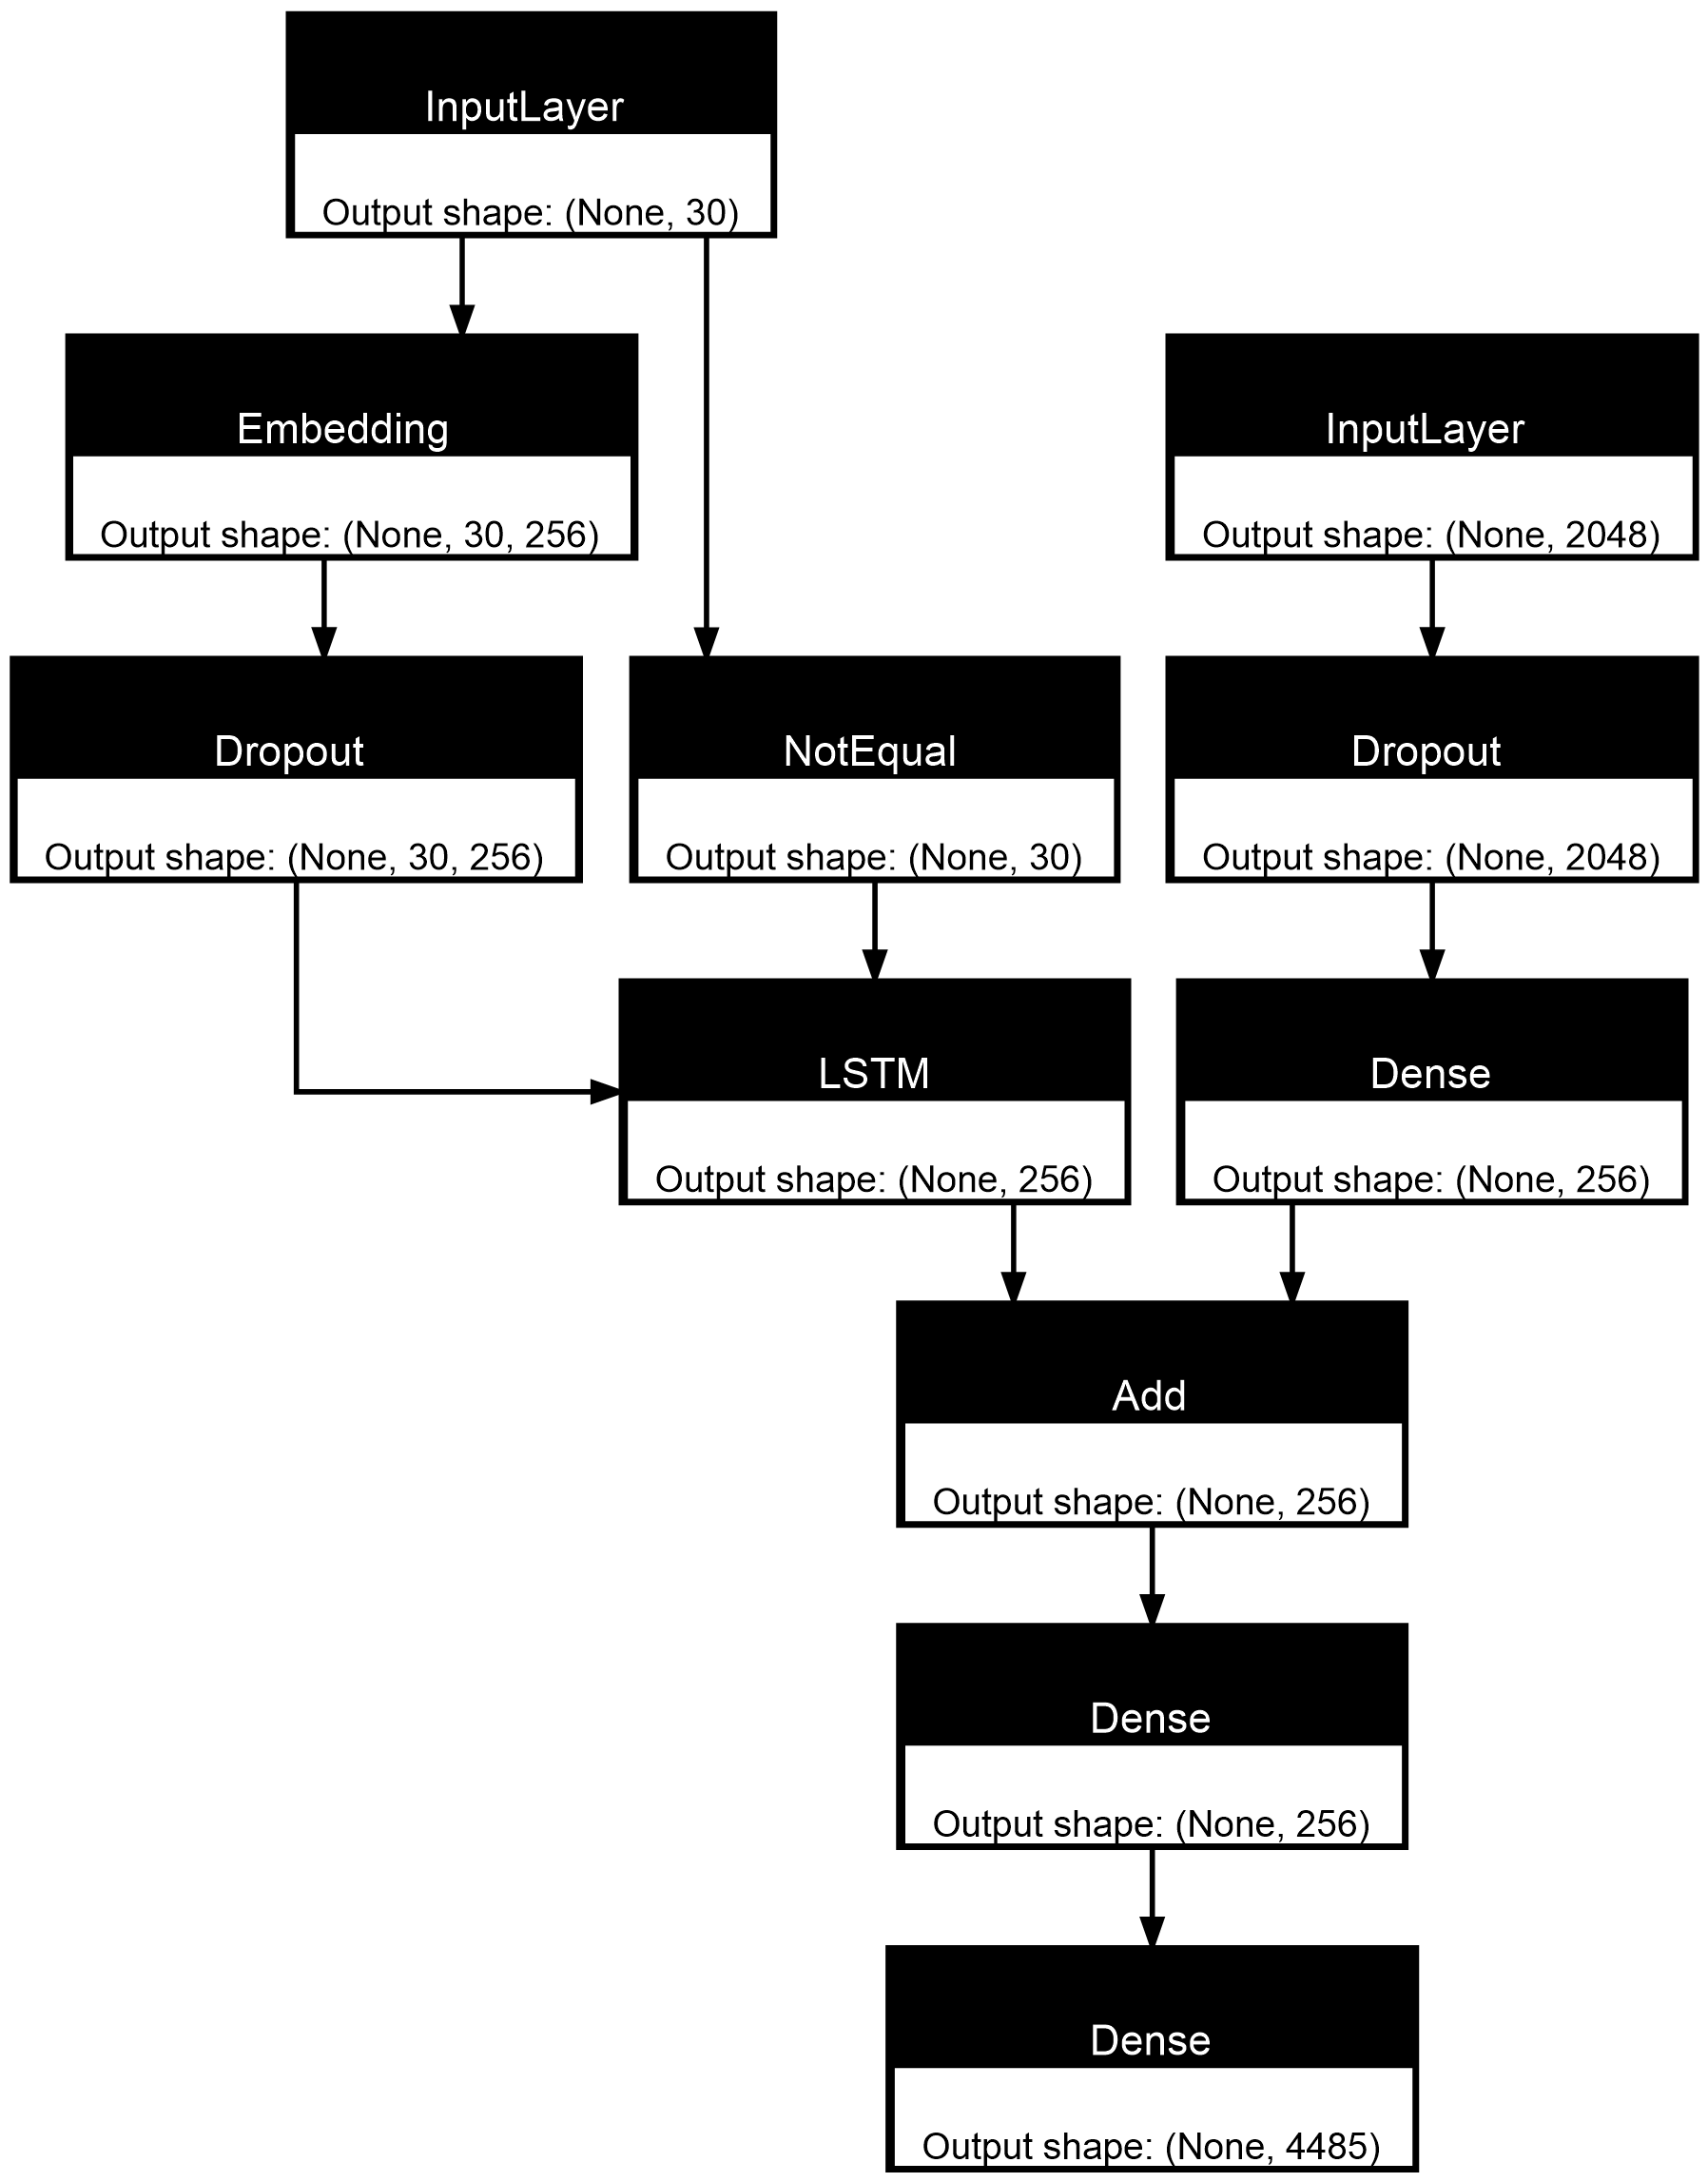

In [35]:
plot_model(model, to_file='model.png', show_shapes=True)

## Reducing Overfitting

In [36]:
# Define the file path pattern for saving model checkpoints
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.keras'

# Define the checkpoint callback
callbacks = [
    ModelCheckpoint(
        filepath=filepath,  # File path pattern
        save_best_only=True,  # Save only the best model
        monitor='val_loss'  # Metric to monitor for saving the best model
    )
]


### Make sure feature data and target data share the same first dimension

In [37]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (72253, 2048)
shape of train_x2  (72253, 30)
shape of train_y  (72253, 4485)

shape of validate_x1  (10284, 2048)
shape of validate_x2  (10284, 30)
shape of validate_y  (10284, 4485)


## Train the model using training data and validation data

# Training Model - Part 1 

In [38]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 20,            
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y)) 

Epoch 1/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 115s 49ms/step - loss: 5.4493 - val_loss: 4.4382
Epoch 2/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 136s 60ms/step - loss: 4.2110 - val_loss: 4.2186
Epoch 3/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 128s 57ms/step - loss: 3.8115 - val_loss: 4.1960
Epoch 4/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 129s 57ms/step - loss: 3.5429 - val_loss: 4.1812
Epoch 5/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 126s 56ms/step - loss: 3.3230 - val_loss: 4.2687
Epoch 6/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 130s 57ms/step - loss: 3.1794 - val_loss: 4.3520
Epoch 7/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 123s 55ms/step - loss: 3.0304 - val_loss: 4.5850
Epoch 8/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 129s 57ms/step - loss: 2.9141 - val_loss: 4.6242
Epoch 9/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 148s 66ms/step - loss: 2.7996 - val_loss: 4.7573
Epoch 10/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 156s 69ms/step - loss: 2.7227 - val_loss: 4.9290
Epoch 11/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 201s 89ms/step - loss: 2.6141 - val_loss: 5.02

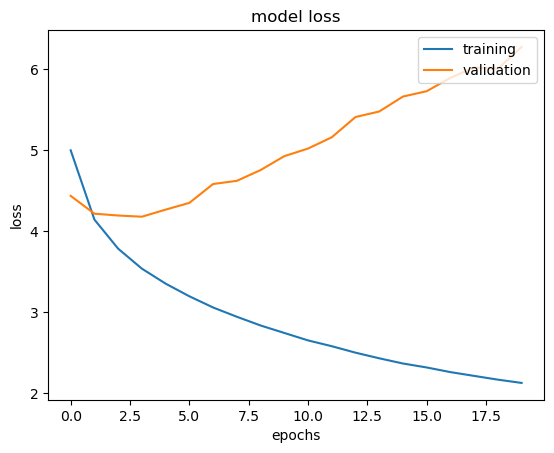

In [39]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [40]:
# saving the model with last parameter 
model.save('./latest_model1_n.keras')

# Evaluate the model  - Part 1

In [45]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
#     model = VGG16()
    model = ResNet50()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None
 

In [46]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

## Evaluating model on training images using the latest model

Latest model has training loss 2.38 and validation loss as 6.04, i.e. it has overfitted so we can expect that it will perform better on the training images than the test images

Predicted caption ->  startseq man and woman are sitting on round bench endseq



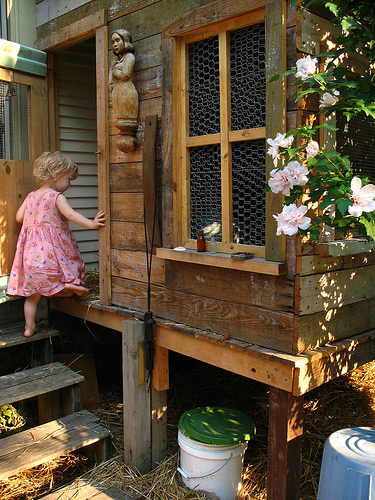


Actual caption ->  startseq child in pink dress is climbing up set of stairs in an entry way endseq
*********************************************************************

Predicted caption ->  startseq black and white dog is running in the grass endseq



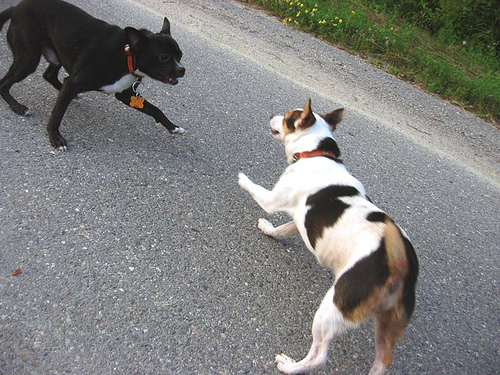


Actual caption ->  startseq black dog and spotted dog are fighting endseq
*********************************************************************

Predicted caption ->  startseq man in blue shirt and hat is shoveling snow near sunny day endseq



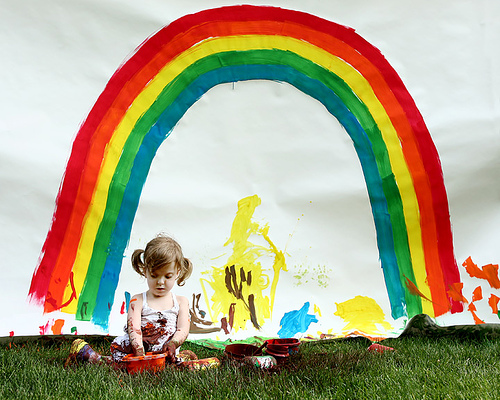


Actual caption ->  startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
*********************************************************************

Predicted caption ->  startseq boy in blue shirt is riding bike down the street endseq



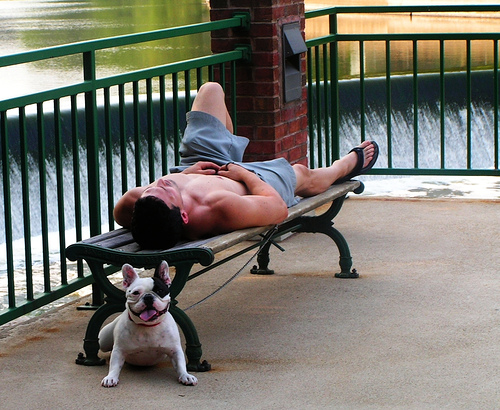


Actual caption ->  startseq man lays on bench while his dog sits by him endseq
*********************************************************************

Predicted caption ->  startseq man in black jacket and sunglasses wears vest hat endseq



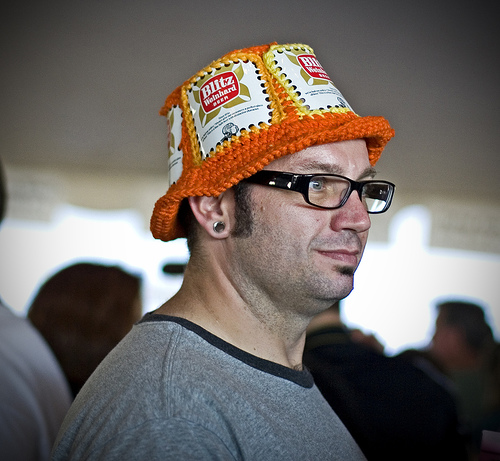


Actual caption ->  startseq man in an orange hat starring at something endseq
*********************************************************************

Predicted caption ->  startseq boy in blue shirt is jumping on the swings endseq



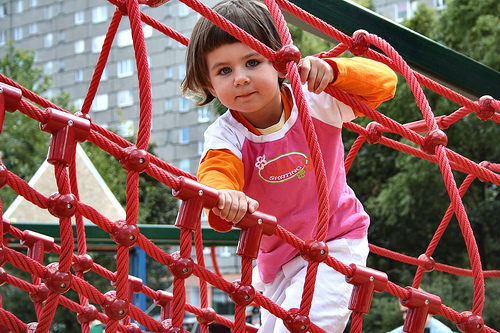


Actual caption ->  startseq child playing on rope net endseq
*********************************************************************

Predicted caption ->  startseq black and white dog is jumping over log in the woods endseq



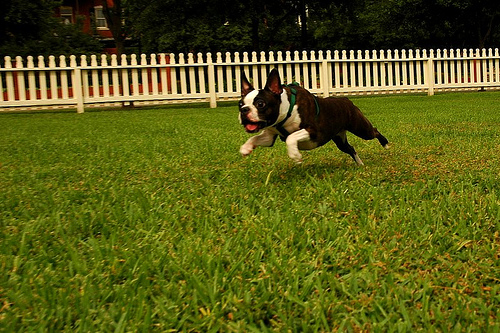


Actual caption ->  startseq black and white dog is running in grassy garden surrounded by white fence endseq
*********************************************************************

Predicted caption ->  startseq brown dog is jumping over log in the sand endseq



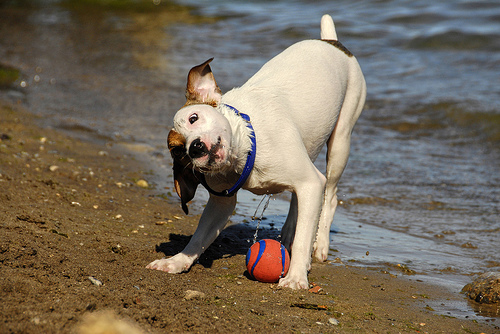


Actual caption ->  startseq dog shakes its head near the shore red ball next to it endseq
*********************************************************************

Predicted caption ->  startseq boy in blue shirt is sitting on the roll of wooden structure endseq



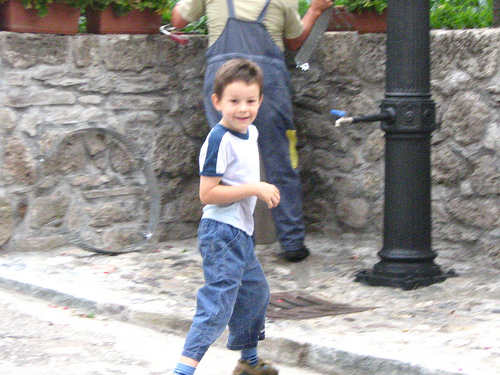


Actual caption ->  startseq boy smiles in front of stony wall in city endseq
*********************************************************************

Predicted caption ->  startseq black dog is running on the sand endseq



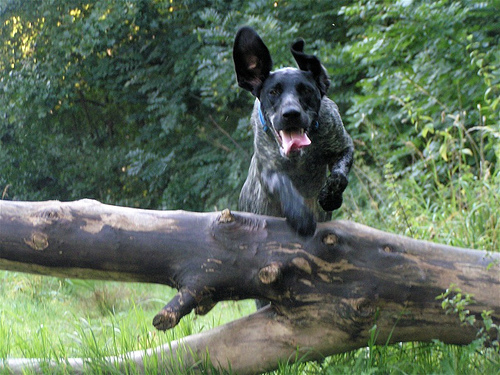


Actual caption ->  startseq black dog leaps over log endseq
*********************************************************************



In [61]:
from tensorflow.keras.models import load_model
# load the model
modl = load_model('./latest_model1_n.keras')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = max_len

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    display(Image(image_dataset_path+'/'+ train_validate_images[count] + '.jpg'))
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

### Not bad 

## Evaluating model on test images using the latest model

Predicted caption ->  startseq his dog stands brown on has does


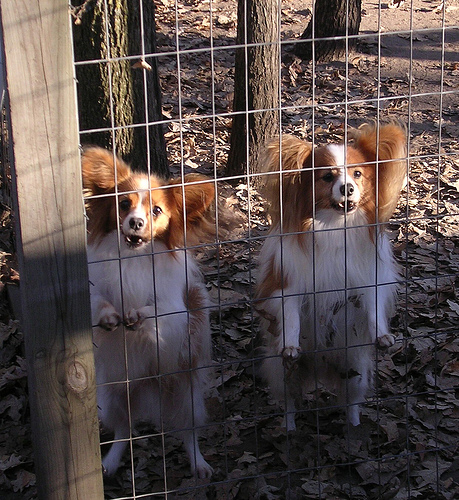

Actual caption ->  startseq two brown and white dogs lift their ears and look through fence endseq
*********************************************************************

Predicted caption ->  startseq children and boy girl on has white


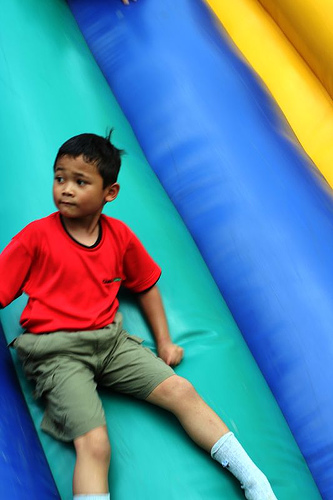

Actual caption ->  startseq boy goes down an inflatable slide endseq
*********************************************************************

Predicted caption ->  startseq his dog stands brown on has does


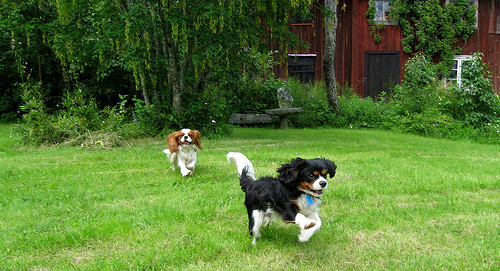

Actual caption ->  startseq one brown and white dog chasing black and white dog through the grass endseq
*********************************************************************

Predicted caption ->  startseq man and one girl on goggles and


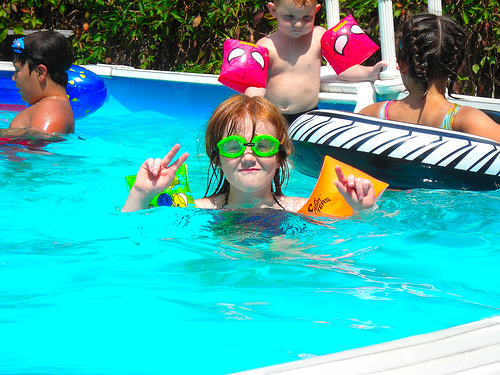

Actual caption ->  startseq girl in pool wearing goggles and surrounded by other children endseq
*********************************************************************

Predicted caption ->  startseq man and one girl on goggles and in bicycle endseq


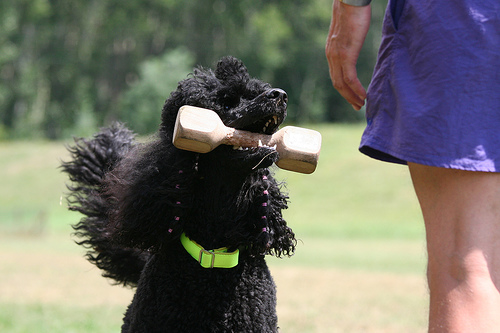

Actual caption ->  startseq black dog has dumbbell in his mouth endseq
*********************************************************************

Predicted caption ->  startseq black and his dog stands girl on


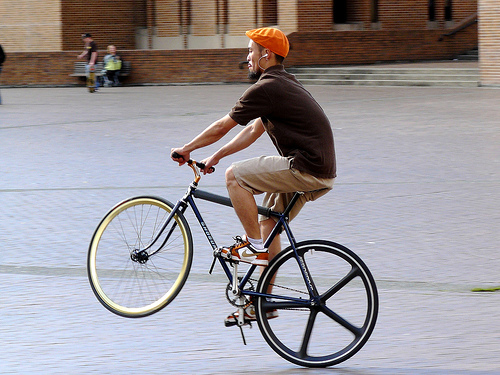

Actual caption ->  startseq man does wheelie on his bicycle on the sidewalk endseq
*********************************************************************

Predicted caption ->  startseq grass through chasing lift goggles and in bicycle endseq


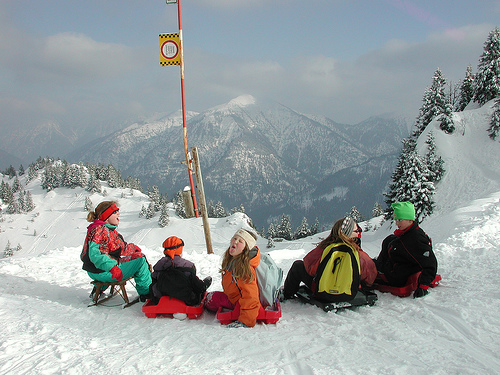

Actual caption ->  startseq group is sitting around snowy crevasse endseq
*********************************************************************

Predicted caption ->  startseq black on


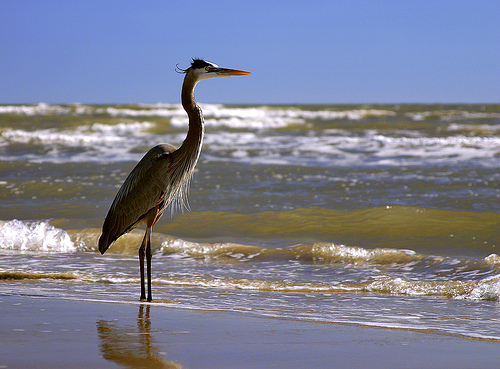

Actual caption ->  startseq grey bird stands majestically on beach while waves roll in endseq
*********************************************************************

Predicted caption ->  startseq black and his


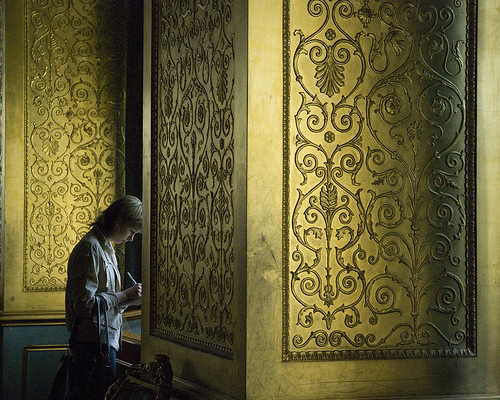

Actual caption ->  startseq person stands near golden walls endseq
*********************************************************************

Predicted caption ->  startseq black and one girl on


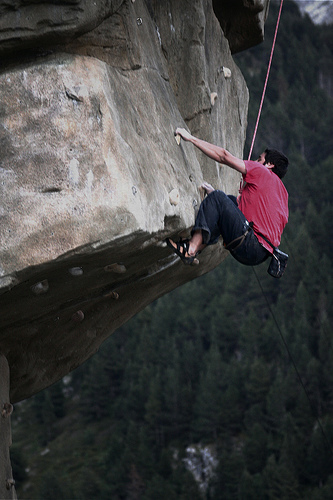

Actual caption ->  startseq man in pink shirt climbs rock face endseq
*********************************************************************



In [64]:
# load the model
modl = load_model('./latest_model1_n.keras')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = max_len

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    display(Image(image_dataset_path+'/'+ test_images[count] + '.jpg'))
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()


### Very Bad ...as expected

## Evaluation on the test images with model with val_loss 4.235

Predicted caption ->  startseq his dog stands brown on wearing and in wheelie endseq


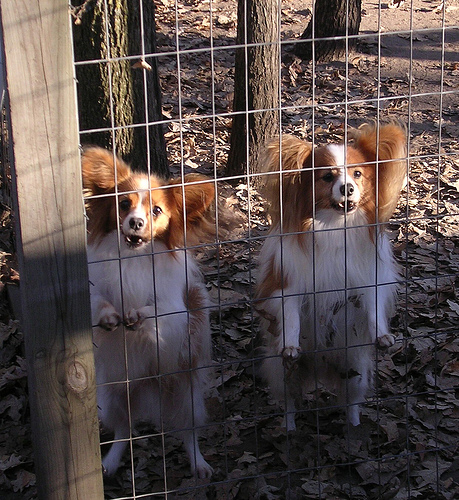

Actual caption ->  startseq two brown and white dogs lift their ears and look through fence endseq
*********************************************************************

Predicted caption ->  startseq man and boy girl on goggles white in


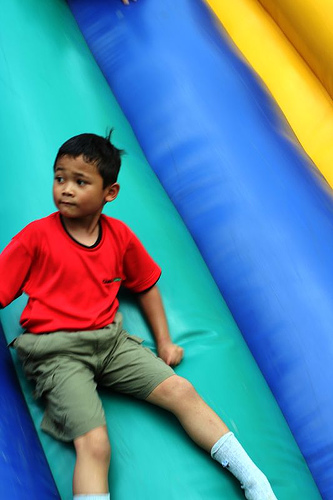

Actual caption ->  startseq boy goes down an inflatable slide endseq
*********************************************************************

Predicted caption ->  startseq his dog stands brown on wearing and in wheelie endseq


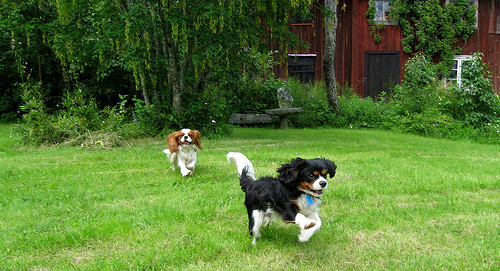

Actual caption ->  startseq one brown and white dog chasing black and white dog through the grass endseq
*********************************************************************

Predicted caption ->  startseq man and boy girl on goggles white in while endseq


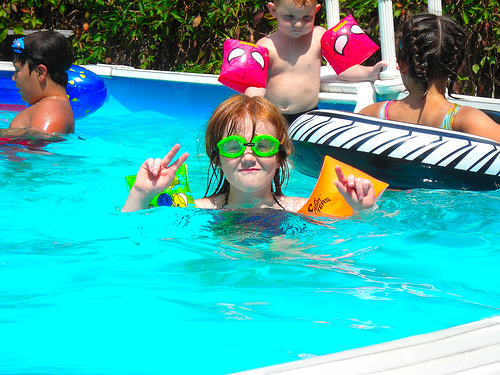

Actual caption ->  startseq girl in pool wearing goggles and surrounded by other children endseq
*********************************************************************

Predicted caption ->  startseq man and boy girl on goggles white in while endseq


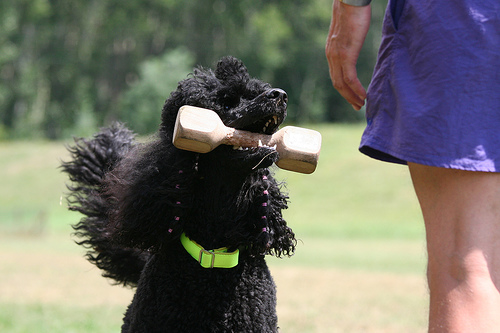

Actual caption ->  startseq black dog has dumbbell in his mouth endseq
*********************************************************************

Predicted caption ->  startseq black and boy girl on goggles white in


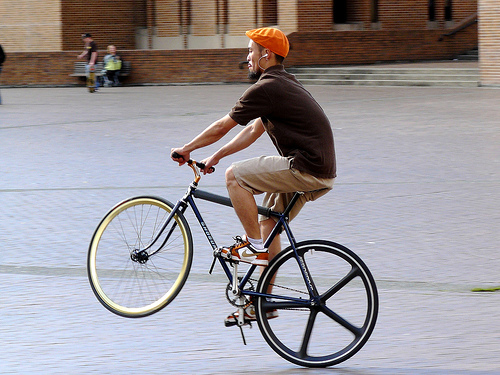

Actual caption ->  startseq man does wheelie on his bicycle on the sidewalk endseq
*********************************************************************

Predicted caption ->  startseq black and boy


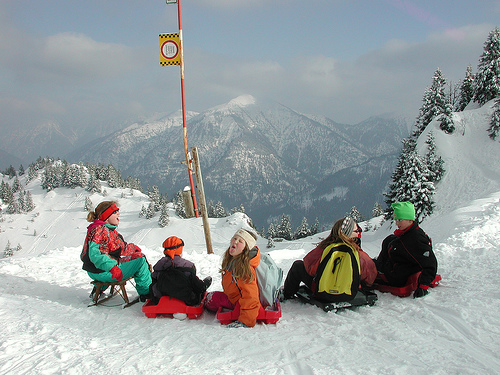

Actual caption ->  startseq group is sitting around snowy crevasse endseq
*********************************************************************

Predicted caption ->  startseq black and one


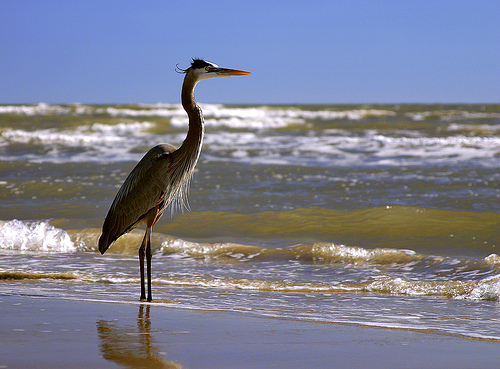

Actual caption ->  startseq grey bird stands majestically on beach while waves roll in endseq
*********************************************************************

Predicted caption ->  startseq black and boy girl on goggles white in


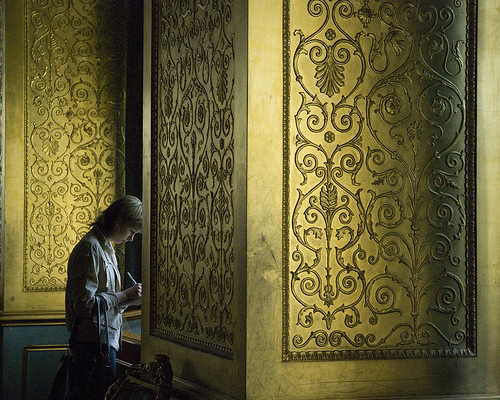

Actual caption ->  startseq person stands near golden walls endseq
*********************************************************************

Predicted caption ->  startseq black and one girl on goggles white in fence endseq


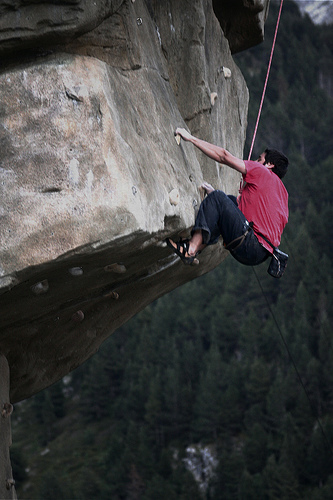

Actual caption ->  startseq man in pink shirt climbs rock face endseq
*********************************************************************



In [65]:
# load the model
modl = load_model('./model-ep03-loss3.786-val_loss4.196.keras')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = max_len

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    display(Image(image_dataset_path+'/'+ test_images[count] + '.jpg'))
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

### Very poor

## Evaluation on the training images with model with validation loss 4.23

Predicted caption ->  startseq man in black shirt and black shirt is sitting on the camera endseq


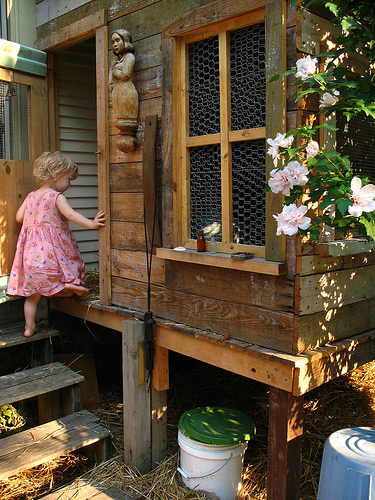

Actual caption ->  startseq child in pink dress is climbing up set of stairs in an entry way endseq
*********************************************************************

Predicted caption ->  startseq black and white dog is running in the grass endseq


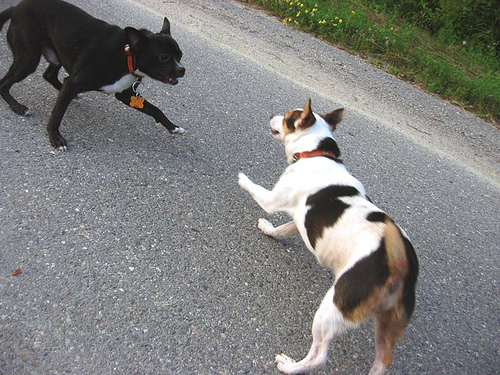

Actual caption ->  startseq black dog and spotted dog are fighting endseq
*********************************************************************

Predicted caption ->  startseq boy in red shirt is standing on the beach endseq


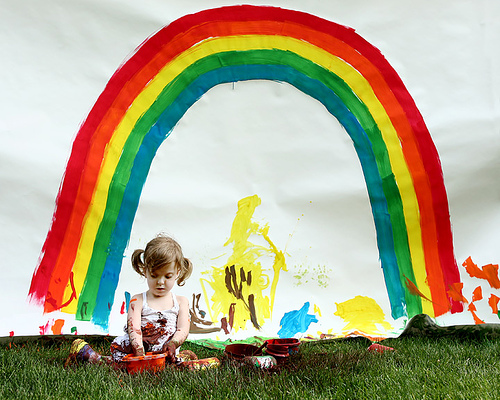

Actual caption ->  startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
*********************************************************************

Predicted caption ->  startseq dog is jumping through the air endseq


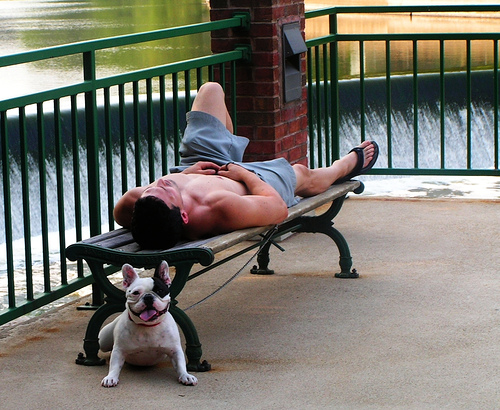

Actual caption ->  startseq man lays on bench while his dog sits by him endseq
*********************************************************************

Predicted caption ->  startseq man in black shirt and black shirt and black shirt is sitting on the camera endseq


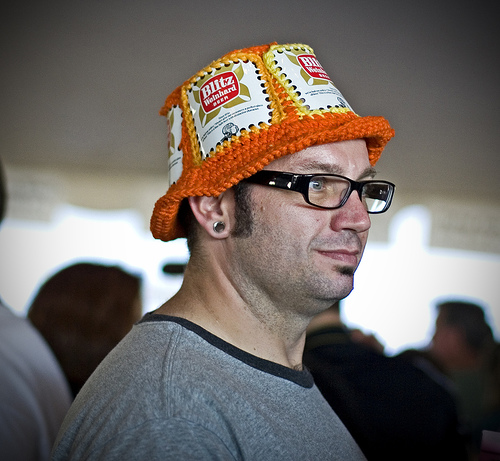

Actual caption ->  startseq man in an orange hat starring at something endseq
*********************************************************************

Predicted caption ->  startseq boy in red shirt is jumping down the beach endseq


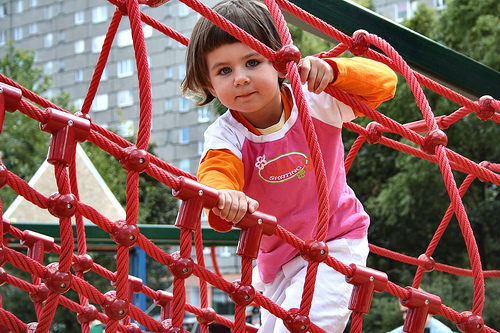

Actual caption ->  startseq child playing on rope net endseq
*********************************************************************

Predicted caption ->  startseq black and white dog is running in the grass endseq


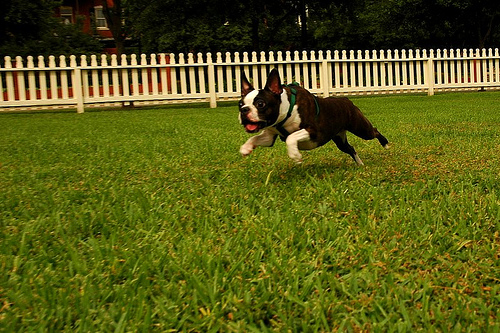

Actual caption ->  startseq black and white dog is running in grassy garden surrounded by white fence endseq
*********************************************************************

Predicted caption ->  startseq dog is running through the water endseq


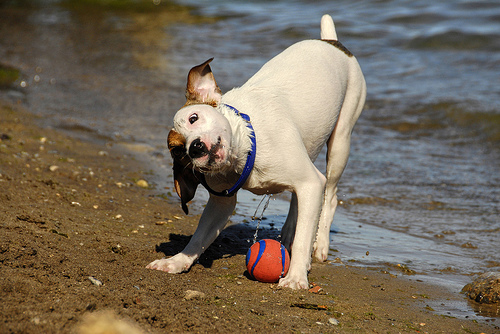

Actual caption ->  startseq dog shakes its head near the shore red ball next to it endseq
*********************************************************************

Predicted caption ->  startseq boy in red shirt is sitting on the camera endseq


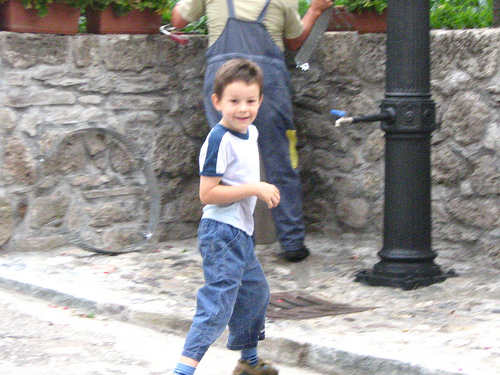

Actual caption ->  startseq boy smiles in front of stony wall in city endseq
*********************************************************************

Predicted caption ->  startseq black dog is running through the water endseq


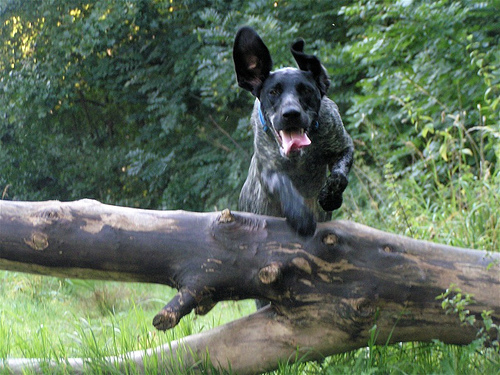

Actual caption ->  startseq black dog leaps over log endseq
*********************************************************************



In [58]:
# load the model
modl = load_model('./model-ep04-loss3.540-val_loss4.181.keras')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = max_len

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
#     print(photo)
    display(Image(image_dataset_path+'/'+ train_validate_images[count] + '.jpg'))
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

But still model has performed very bad, lets tune model to perform better

In [57]:
from IPython.display import display